# Autoencoder for ECG

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = '/content/drive/MyDrive/notebooks_AD/data'

X_train = np.loadtxt(file_path+'/X_train.txt')
y_train = np.loadtxt(file_path+'/y_train.txt')

X_test = np.loadtxt(file_path+'/X_test.txt')
y_test = np.loadtxt(file_path+'/y_test.txt')

## Play with the data

In [5]:
print(X_train.shape, y_train.shape)

(4500, 140) (4500,)


In [6]:
print(X_test.shape, y_test.shape)

(500, 140) (500,)


## Prepare the data

In [7]:
normal_idx = y_train==0
anomaly_idx = y_train==1 

In [8]:
X_normal = X_train[normal_idx]

In [9]:
X_normal.shape

(2627, 140)

## Build the model using Functional API

Encoder

In [10]:
input = Input(shape=(X_train.shape[1],), name='encoder_input')
x = input

for current_units in [7,3]:
    x = Dense( units=current_units, activation='relu', name=f'encoder-{current_units}' )(x)

latent = Dense(units=2, activation='linear',  name='latent_vector')(x)

encoder = Model(inputs=input, outputs=latent, name='encoder')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 140)]             0         
_________________________________________________________________
encoder-7 (Dense)            (None, 7)                 987       
_________________________________________________________________
encoder-3 (Dense)            (None, 3)                 24        
_________________________________________________________________
latent_vector (Dense)        (None, 2)                 8         
Total params: 1,019
Trainable params: 1,019
Non-trainable params: 0
_________________________________________________________________


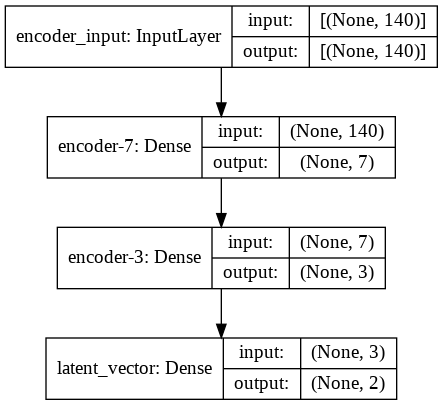

In [11]:
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Decoder

In [12]:
latent_input = Input(shape=(2,), name='decoder_input')
x = latent_input

for current_units in [3, 7]:
    x = Dense( units=current_units, activation='relu', name=f'decoder-{current_units}' )(x)

output = Dense( units=X_train.shape[1], activation='sigmoid', name='decoder_output')(x)

decoder = Model(inputs=latent_input, outputs=output, name='decoder')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder-3 (Dense)            (None, 3)                 9         
_________________________________________________________________
decoder-7 (Dense)            (None, 7)                 28        
_________________________________________________________________
decoder_output (Dense)       (None, 140)               1120      
Total params: 1,157
Trainable params: 1,157
Non-trainable params: 0
_________________________________________________________________


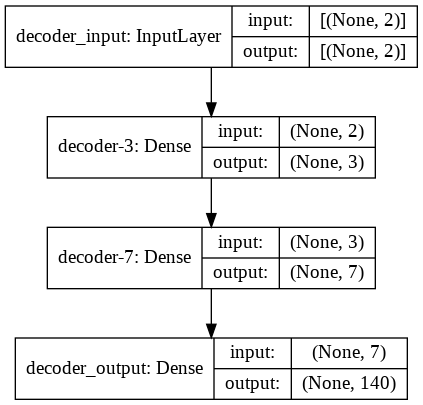

In [13]:
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Build the autoencoder

In [14]:
autoencoder = Model(inputs=input, outputs=decoder(encoder(input)), name='autoencoder')

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 140)]             0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 1019      
_________________________________________________________________
decoder (Functional)         (None, 140)               1157      
Total params: 2,176
Trainable params: 2,176
Non-trainable params: 0
_________________________________________________________________


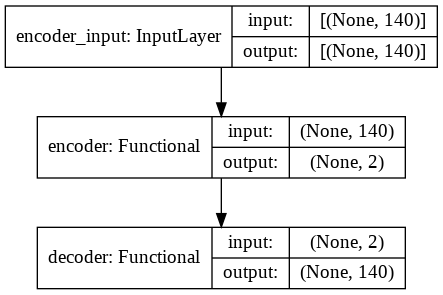

In [15]:
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

## Compile the model

In [16]:
autoencoder.compile(loss='mse', optimizer='adam')

## Train the model

In [17]:
result = autoencoder.fit(x=X_normal, y=X_normal, epochs=50, batch_size=512)

Epoch 1/50
6/6 [==============================] - 1s 3ms/step - loss: 0.0275
Epoch 2/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 3/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 4/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 5/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 6/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 7/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 8/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 9/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 10/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 11/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 12/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 13/50
6/6 [==============================] - 0s 3ms/step - loss: 0.

## Evaluate the model

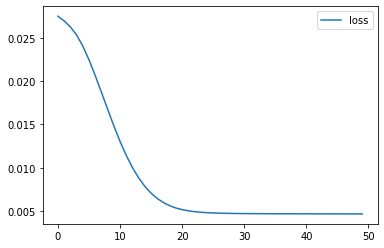

In [18]:
plt.plot(result.history['loss'], label='loss')
plt.legend()

## Make Predictions

In [19]:
X_pred = autoencoder.predict(X_test)

In [20]:
mse = np.mean(np.power(X_test - X_pred, 2), axis=1)

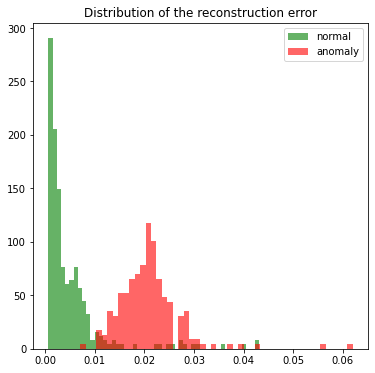

In [21]:
normal = mse[y_test==0]
anomaly = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal, bins=50, density=True, label="normal", alpha=.6, color="green")
ax.hist(anomaly, bins=50, density=True, label="anomaly", alpha=.6, color="red")

plt.title("Distribution of the reconstruction error")
plt.legend()
plt.show()

In [22]:
threshold = 0.013
cm = confusion_matrix(y_test, [ 0 if e <= threshold else 1  for e in  mse])
cm

array([[274,  18],
       [ 11, 197]])

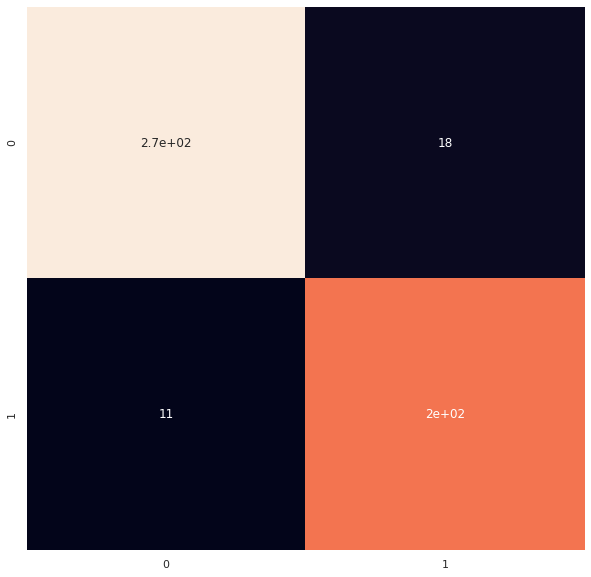

In [23]:
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(cm,annot=True,cbar=False)

In [24]:
x2d = autoencoder.layers[1].predict(X_test)

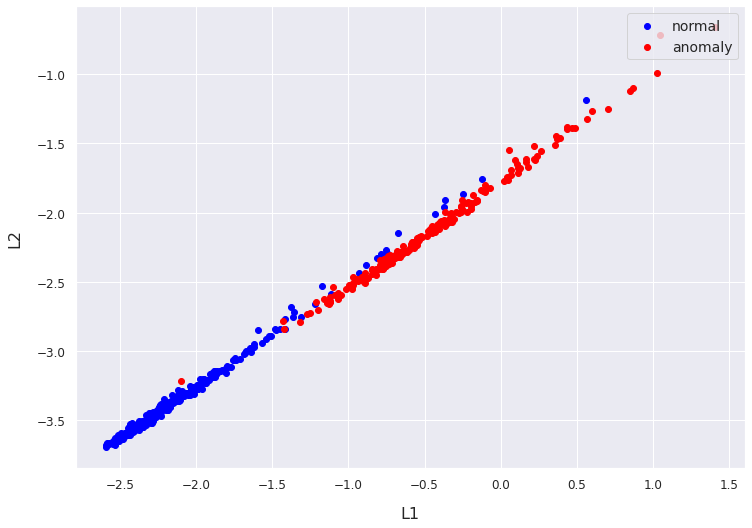

In [25]:
fig1 = plt.figure(figsize=(12, 8.5))
ax1 = fig1.add_subplot(111)
ax1.scatter(x2d[y_test==0,0], x2d[y_test==0,1], color='blue', label='normal')
ax1.scatter(x2d[y_test==1,0], x2d[y_test==1,1], color='red', label='anomaly')

ax1.set_xlabel('L1', fontsize=16)
ax1.set_ylabel('L2', fontsize=16)

ax1.tick_params(axis='both', labelsize=12)
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.legend(loc='upper right', fontsize=14)